In [1]:
from agents.theoritical_agent import *
from agents.angle_agent import *
from agents.observation_agent import *
from agents.control_rnn import *
from agents.pre_rnn import *
from agents.post_rnn import *
from agents.universal_rnn import *
from env import *
import numpy as np
from tf_to_mat import *

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

2024-03-11 11:42:50.685700: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-11 11:42:50.712245: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 11:42:50.712273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 11:42:50.712956: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 11:42:50.717163: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-11 11:42:50.717429: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
tf.keras.backend.set_floatx('float64')

In [3]:
#Parameters
kappa = 0.5 #Kappa for the von mises
deck_size = 12 #length sequences
optimal_training = False #Training on optimal labels instead of real ones

nb = 1 #Nb of networks to train
batch_size = 2000 #Batch size for the training (length of the training)
rnn_noise = None #Std for noisy networks (put None if you don't want a noisy network)
random_training = True #Training on sequence of random length chosen uniformely in [|1,12|]
separated_params = (10,2) #(Nb of neurons which will see the first part of the input,size of the first part of the input)

free_feedback = True #True = free feedback in the recurrent network / False = only REF -> SEQ feedbacks

activation = 'tanh' #Activation function

separated = False #Separated network

condition = 'pre'

In [4]:
if optimal_training:
    random_training = False #Random training cannot be used with random_training (technical issues)

### Training

In [5]:
for i in range(5,10):
    env = Env(deck_size,kappa=kappa,condition=condition)
    agent = UniversalRNN(64,activation=activation,noise=i/10)
    agent.postname = condition #Set path name for saving and loading
    agent.train(env,2000,batch_size=batch_size,nb_fit=5,verbose=1)
    agent.save('UniversalRNN-'+str(condition)+'-'+str(i))
    np.save('models/UniversalRNN-'+str(condition)+'-'+str(i)+'/scores.npy',np.array(agent.scores))

0 0.51
1 0.5057499999999999
2 0.5048333333333334
3 0.506875
4 0.5055999999999999
5 0.5027499999999999
6 0.503
7 0.5023124999999999
8 0.5002777777777777
9 0.50105
10 0.5007499999999999
11 0.5009499999999999
12 0.5019
13 0.4997
14 0.5006999999999999
15 0.5010999999999999
16 0.49974999999999997
17 0.49905
18 0.50105
19 0.49894999999999995
20 0.49995
21 0.49735000000000007
22 0.4958
23 0.49765
24 0.4969
25 0.4967
26 0.49785
27 0.49949999999999994
28 0.4981
29 0.5013
30 0.50005
31 0.5016499999999999
32 0.50345
33 0.5018499999999999
34 0.5013
35 0.5025000000000001
36 0.5017499999999999
37 0.5012
38 0.50455
39 0.5042000000000001
40 0.507
41 0.5062499999999999
42 0.5050999999999999
43 0.5045
44 0.50565
45 0.50555
46 0.5062499999999999
47 0.50695
48 0.5039499999999999
49 0.5029
50 0.49994999999999995
51 0.50165
52 0.50225
53 0.5031000000000001
54 0.50205
55 0.50085
56 0.5000499999999999
57 0.49955
58 0.50095
59 0.4993
60 0.49850000000000005
61 0.4989
62 0.49660000000000004
63 0.4962000000000001

In [ ]:
env = Env(deck_size,kappa=kappa,condition=condition)
agent = UniversalRNN(64,activation=activation,noise=rnn_noise)
agent.postname = condition #Set path name for saving and loading

In [ ]:
agent.train(env,3000,batch_size=batch_size,nb_fit=5,verbose=1)
agent.save('UniversalRNN-'+str(condition)+'-'+str(rnn_noise)+'-10')

0 0.51
1 0.5065
2 0.5076666666666666
3 0.50875
4 0.5132000000000001
5 0.5180833333333333
6 0.5250714285714286
7 0.530375
8 0.5363888888888889
9 0.54105
10 0.5488999999999999
11 0.5565500000000001
12 0.56245
13 0.56845
14 0.5730000000000001
15 0.5738000000000001
16 0.5734999999999999
17 0.57485
18 0.57505
19 0.5737
20 0.5735499999999999
21 0.5736
22 0.57465
23 0.5737500000000001
24 0.5744
25 0.57805
26 0.5805
27 0.5826
28 0.5837999999999999
29 0.5843999999999999
30 0.5843
31 0.58475
32 0.58455
33 0.5867
34 0.58665
35 0.58735
36 0.5855
37 0.58545
38 0.5846500000000001
39 0.5862
40 0.5874499999999999
41 0.5882499999999999
42 0.5891000000000001
43 0.59015
44 0.5932999999999999
45 0.5941
46 0.5987
47 0.5989000000000001
48 0.6
49 0.60115
50 0.6020000000000001
51 0.5983500000000002
52 0.5982000000000001
53 0.5980000000000001
54 0.59405
55 0.59175
56 0.5889
57 0.5883
58 0.5871000000000001
59 0.5880500000000001
60 0.5871999999999999
61 0.5902499999999999
62 0.5910500000000001
63 0.5893499999999

KeyboardInterrupt: 

In [ ]:
agent.save('UniversalRNN-'+str(condition)+'-'+str(rnn_noise)+'-10')

SAVING ['nn', 'out_nn']


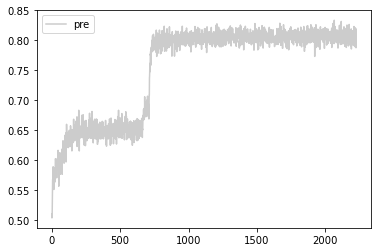

In [ ]:
#Plot accuracies
plt.plot(range(len(agent.scores)),agent.scores,alpha=0.4,color='grey',label=condition)
plt.legend()
plt.show()

### Plots

In [ ]:
env = Env(deck_size,kappa=kappa,condition=condition)
agent = UniversalRNN(64,activation=activation,noise=rnn_noise)
agent.postname = condition #Set path name for saving and loading

In [ ]:
agent.load('UniversalRNN-'+str(condition)+'-'+str(rnn_noise)+'-10')

LOADING ['nn', 'out_nn']


In [ ]:
from sklearn.decomposition import PCA
from analyse.plot_pca import *

In [ ]:
pca_batch_size = 2000 #Batch size to fit the PCA on
pca_axes = [0,1,2] #Axes of the pca to plot (3 max)

nb_variance = 10 #Nb of variance to plot

In [ ]:
#Pre compute batch
batch_obsf = env.sample_batch(pca_batch_size) 
batch_obs = batch_obsf.get('obs')

In [ ]:
#Def residue function
def residue(X,Y):
    from sklearn.linear_model import LinearRegression
    Lg = LinearRegression()
    XX = np.reshape(X,(-1,X.shape[-1]))
    YY = Y
    Lg.fit(YY,XX)
    print("score",Lg.score(YY,XX))
    #assert False
    pred = Lg.predict(YY)
    pred = np.reshape(pred,X.shape)
    return X - pred

In [ ]:
out = agent.nn(batch_obs).numpy()[:,:,:]
choice = agent.predict(batch_obsf).numpy()

In [ ]:
batch_obsf.get('ref')

array([0.78539816, 2.35619449, 5.49778714, ..., 4.71238898, 3.92699082,
       3.92699082])

In [ ]:
#Residue ref
#cosref = np.cos(batch_obsf.get('ref'))[:,None]
#sinref = np.sin(batch_obsf.get('ref'))[:,None]
#ref = np.concatenate([cosref,sinref],axis=1)
#ref = ref[:,None,:].repeat(out.shape[1],axis=1).reshape((-1,2))
#out = residue(out,ref)

#Residue choice
#choice_batch = choice[:,None].repeat(out.shape[1],axis=1).reshape((-1,1))
#out = residue(out, choice_batch)

#Residue mean angle
#mean_angle = np.mean(batch_obsf.get('obs')[:,:,:2],axis=1)[:,None,:].repeat(out.shape[1],axis=1).reshape((-1,2))
#out = residue(out,mean_angle)

In [ ]:
#fit pca
pca = fit_pca(out.reshape((-1,64)),nb_components=nb_variance)
pca_batch = pca.transform(out.reshape((-1,64))).reshape(out.shape[:-1]+(nb_variance,))

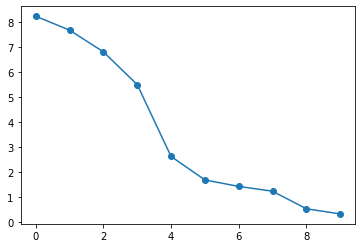

In [ ]:
%matplotlib inline
#plot explained variance
plt.plot(range(nb_variance),pca.explained_variance_,marker='o')
plt.show()

In [ ]:
batch_obsf.get('mean')

array([[3.92699082, 3.92699082, 3.92699082, ..., 3.92699082, 3.92699082,
        3.92699082],
       [5.49778714, 5.49778714, 5.49778714, ..., 5.49778714, 5.49778714,
        5.49778714],
       [5.49778714, 5.49778714, 5.49778714, ..., 5.49778714, 5.49778714,
        5.49778714],
       ...,
       [4.71238898, 4.71238898, 4.71238898, ..., 4.71238898, 4.71238898,
        4.71238898],
       [3.92699082, 3.92699082, 3.92699082, ..., 3.92699082, 3.92699082,
        3.92699082],
       [3.92699082, 3.92699082, 3.92699082, ..., 3.92699082, 3.92699082,
        3.92699082]])

In [ ]:
plt.get_cmap('rainbow')(0),plt.get_cmap('rainbow')(1)

((0.5, 0.0, 1.0, 1.0),
 (0.49215686274509807, 0.012319659535238442, 0.9999810273487268, 1.0))

In [ ]:
#Plot background function
def plot_bg(pca_batch,zorder=0):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('pca1')
    ax.set_ylabel('pca2')
    ax.set_zlabel('pca3')
    colors = [(i/deck_size,(1-i/deck_size),(i-6)**2/36) for i in range(pca_batch.shape[1])]
    cm = plt.get_cmap('rainbow')
    obj = batch_obsf.get('mean')[:,0]/(2*np.pi)
    #mean_angle = np.mean(batch_obsf.get('obs')[:,:,:2],axis=1)
    #obj = (np.arctan2(mean_angle[:,1],mean_angle[:,0])+np.pi)/(2*np.pi)
    #obj = batch_obsf.get('ref')/(2*np.pi)
    #obj = batch_obsf.get('color')/0.5
    obj = choice/0.5
    colors = [[cm(ref) for ref in obj] for i in range(pca_batch.shape[1])]
    unique_refs = np.unique(obj)
    for i,r in enumerate(unique_refs):
        c = cm(r)
        label = str(r)
        ax.plot([0],[0],[0],color=c,label=label,zorder=zorder)
    for i in range(pca_batch.shape[1]):
        ax.scatter(pca_batch[:,i,2],pca_batch[:,i,3],pca_batch[:,i,4],color=colors[i],alpha=0.1,marker='.',zorder=zorder)

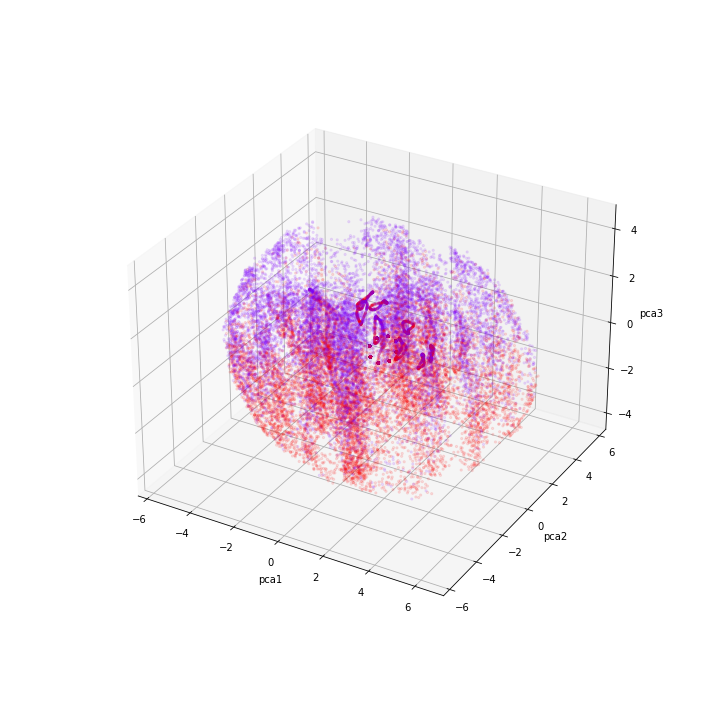

In [ ]:
%matplotlib widget
from mpl_toolkits import mplot3d
plot_bg(pca_batch)
plt.show()